In [3]:
# 모듈 불러오기
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from tqdm import tqdm
import re

In [100]:
senti=pd.read_csv('./data/knu_sentiment_lexicon.csv')
senti

,word,polarity
0,ㅡㅡ,-1
1,ㅠㅠ,-1
2,ㅠ_ㅠ,-1
3,ㅠ,-1
4,ㅜㅡ,-1
...,...,...
14849,(^-^),1
14850,(;_;),-1
14851,(-_-),-1
14852,(-;,1


In [101]:
nouns = pd.read_csv('./data/nouns_df.csv')
nouns = nouns[['명사']]
nouns

,명사
0,"['이대성', '허웅', '제압', '성현', '점슛', '분전', '허웅', '생..."
1,"['진박', '감별', '사가', '쥐락펴락', '나경원', '비판', '응수', ..."
2,"['양금', '국민', '의원', '대구', '북구', '대구', '북구', '주민..."
3,"['김상훈', '국민', '의원', '대구', '서구', '대구', '서구', '주..."
4,"['류성걸', '국민', '의원', '대구', '류성걸', '국민', '의원', '..."
...,...
39940,"['우상혁', '부다페스트', '세계', '육상', '선수권', '남자', '높이뛰..."
39941,"['중소', '벤처기업', '실장', '전보', '중소기업', '정책', '실장',..."
39942,"['유튜버', '김용호', '유튜브', '채널', '강용석', '나이트', '라이브..."
39943,"['윤희', '경찰청장', '충북', '충주시', '중앙', '경찰', '학교', ..."


In [5]:
# 본문내용 안의 공백제거 코드 (명사만 뽑으면 돼서 안함)
# text = news['본문'][0]
# cleaned_text = re.sub(r'\s+', ' ', text)

## 딥러닝 (LSTM)
- 학습데이터 : 본문
- 타겟데이터 : 감성분석결과

In [4]:
# 감성사전
okt = Okt()

total_score = []
for i in tqdm(nouns['명사']):
    try:
        t = okt.normalize(i)
        score = 0
        for w,p in zip(senti['word'], senti['polarity']):
            score += t.count(w)*p
        total_score.append(score)

    except:
        total_score.append(None)

nouns['감성점수'] = total_score
nouns

100%|██████████| 39945/39945 [10:41<00:00, 62.23it/s]


,명사,감성점수
0,"['이대성', '허웅', '제압', '성현', '점슛', '분전', '허웅', '생...",6
1,"['진박', '감별', '사가', '쥐락펴락', '나경원', '비판', '응수', ...",-3
2,"['양금', '국민', '의원', '대구', '북구', '대구', '북구', '주민...",9
3,"['김상훈', '국민', '의원', '대구', '서구', '대구', '서구', '주...",14
4,"['류성걸', '국민', '의원', '대구', '류성걸', '국민', '의원', '...",12
...,...,...
39940,"['우상혁', '부다페스트', '세계', '육상', '선수권', '남자', '높이뛰...",-7
39941,"['중소', '벤처기업', '실장', '전보', '중소기업', '정책', '실장',...",15
39942,"['유튜버', '김용호', '유튜브', '채널', '강용석', '나이트', '라이브...",-8
39943,"['윤희', '경찰청장', '충북', '충주시', '중앙', '경찰', '학교', ...",11


In [5]:
nouns['감성점수'].isna().sum()

0

-14.0

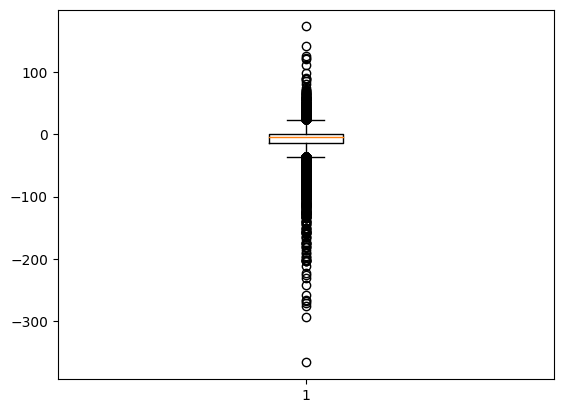

In [6]:
# 감성점수 분포 확인하기
import matplotlib.pyplot as plt

plt.boxplot(nouns['감성점수'])
nouns['감성점수'].quantile(q=0.25)  # 1 분위수

In [7]:
# 중앙값 확인
nouns['감성점수'].median()

-5.0

In [8]:
# 긍정
print((nouns['감성점수'] >= 1.0).value_counts())

# 부정
print((nouns['감성점수'] <= -14.0).value_counts())

# 중립
print(((nouns['감성점수'] > -14.0) & (nouns['감성점수'] < 1.0)).value_counts()) 

감성점수
False    28900
True     11045
Name: count, dtype: int64
감성점수
False    29855
True     10090
Name: count, dtype: int64
감성점수
False    21135
True     18810
Name: count, dtype: int64


In [11]:
# 긍정 : 1 / 중립 : 0 / 부정 : -1
nouns['감성분석결과'] = nouns['감성점수'].apply(lambda x: 1 if x>=1.0 else -1 if x<=-14.0 else 0) 
nouns[nouns['감성분석결과'] == 0]['감성분석결과'].value_counts()
nouns

# csv파일로 저장
nouns.to_csv('senti_result.csv', encoding='utf-8', index=False)

#### LSTM 모델

In [15]:
nouns = pd.read_csv('./senti_result.csv', encoding='utf-8')
nouns

,명사,감성점수,감성분석결과
0,"['이대성', '허웅', '제압', '성현', '점슛', '분전', '허웅', '생...",6,1
1,"['진박', '감별', '사가', '쥐락펴락', '나경원', '비판', '응수', ...",-3,0
2,"['양금', '국민', '의원', '대구', '북구', '대구', '북구', '주민...",9,1
3,"['김상훈', '국민', '의원', '대구', '서구', '대구', '서구', '주...",14,1
4,"['류성걸', '국민', '의원', '대구', '류성걸', '국민', '의원', '...",12,1
...,...,...,...
39940,"['우상혁', '부다페스트', '세계', '육상', '선수권', '남자', '높이뛰...",-7,0
39941,"['중소', '벤처기업', '실장', '전보', '중소기업', '정책', '실장',...",15,1
39942,"['유튜버', '김용호', '유튜브', '채널', '강용석', '나이트', '라이브...",-8,0
39943,"['윤희', '경찰청장', '충북', '충주시', '중앙', '경찰', '학교', ...",11,1


In [16]:
nouns['명사'][0].replace('[', '').replace(']', '').replace("'", '').replace(',', '')
nouns['명사'] = nouns['명사'].apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').replace(',', ''))
nouns

,명사,감성점수,감성분석결과
0,이대성 허웅 제압 성현 점슛 분전 허웅 생애 점슛 콘테스트 우승 반도 덩크슛 챔피언...,6,1
1,진박 감별 사가 쥐락펴락 나경원 비판 응수 국민 장제원 의원 나경원 의원 나경원 국...,-3,0
2,양금 국민 의원 대구 북구 대구 북구 주민 양금 국민 의원 중앙 정치 활동 긍정 평...,9,1
3,김상훈 국민 의원 대구 서구 대구 서구 주민 출신 김상훈 국민 의원 의정 활동 전반...,14,1
4,류성걸 국민 의원 대구 류성걸 국민 의원 전반 의정 활동 대한 대구 주민 평가 긍정...,12,1
...,...,...,...
39940,우상혁 부다페스트 세계 육상 선수권 남자 높이뛰기 예선 로이터 우상혁 부다페스트 세...,-7,0
39941,중소 벤처기업 실장 전보 중소기업 정책 실장 대희 상공 정책 실장 영준 국장 전보 ...,15,1
39942,유튜버 김용호 유튜브 채널 강용석 나이트 라이브 캡처 연예 출신 유튜버 김용호 조국...,-8,0
39943,윤희 경찰청장 충북 충주시 중앙 경찰 학교 신임 경찰 졸업식 신임 경찰 악수 최근 ...,11,1


In [17]:
from sklearn.model_selection import train_test_split

data = nouns['명사']
target = nouns['감성분석결과']

train_X, test_X, train_y, test_y = train_test_split(data, target, 
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=42)

In [19]:
train_y

26162    0
13487    0
35100    0
8680     0
35376   -1
        ..
39920   -1
12783    0
7249     0
35553    0
4061     0
Name: 감성분석결과, Length: 31956, dtype: int64

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [21]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
tokenizer.fit_on_texts(test_X)

tokens_train = tokenizer.texts_to_sequences(train_X)
tokens_test = tokenizer.texts_to_sequences(test_X)

In [22]:
train_y = to_categorical(train_y, num_classes=3)
test_y = to_categorical(test_y, num_classes=3)

In [23]:
train_y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

---

### 처음 모델 돌린 거 

In [24]:
max_features = 100000  # 특성으로 사용할 단어의 수
maxlen = 100  # 시퀀스 길이

# 시퀀스 길이 맞춤
train_X = pad_sequences(tokens_train, maxlen=maxlen)
test_X = pad_sequences(tokens_test, maxlen=maxlen)

# LSTM 모델 구축

embedding_dim = 128
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# 체크포인트와 얼리스탑 콜백 설정
checkpoint_path = 'checkpoint/model_lstm.h5'  # 체크포인트 경로
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# 모델 학습
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), callbacks=[checkpoint, early_stopping])

Epoch 1/10
999/999 [==============================] - ETA: 0s - loss: 0.7560 - accuracy: 0.6522
Epoch 1: val_loss improved from inf to 0.66417, saving model to checkpoint\model_lstm.h5


c:\Users\LG\anaconda3\envs\daegu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


999/999 [==============================] - 154s 154ms/step - loss: 0.7560 - accuracy: 0.6522 - val_loss: 0.6642 - val_accuracy: 0.7046
Epoch 2/10
999/999 [==============================] - ETA: 0s - loss: 0.5092 - accuracy: 0.7893
Epoch 2: val_loss did not improve from 0.66417
999/999 [==============================] - 229s 230ms/step - loss: 0.5092 - accuracy: 0.7893 - val_loss: 0.6754 - val_accuracy: 0.7082
Epoch 3/10
999/999 [==============================] - ETA: 0s - loss: 0.3491 - accuracy: 0.8654
Epoch 3: val_loss did not improve from 0.66417
999/999 [==============================] - 174s 174ms/step - loss: 0.3491 - accuracy: 0.8654 - val_loss: 0.7430 - val_accuracy: 0.7185
Epoch 4/10
999/999 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9093
Epoch 4: val_loss did not improve from 0.66417
999/999 [==============================] - 176s 176ms/step - loss: 0.2409 - accuracy: 0.9093 - val_loss: 0.8618 - val_accuracy: 0.7177
Epoch 4: early stopping


### 두번째 stratify=target 주고 돌린 거

In [25]:
# 체크포인트와 얼리스탑 콜백 설정
checkpoint_path = 'checkpoint/model_lstm2.h5'  # 체크포인트 경로
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# 모델 학습
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_data=(test_X, test_y), callbacks=[checkpoint, early_stopping])

Epoch 1/10
999/999 [==============================] - ETA: 0s - loss: 0.8076 - accuracy: 0.6199
Epoch 1: val_loss improved from inf to 0.68012, saving model to checkpoint\model_lstm2.h5


c:\Users\LG\anaconda3\envs\daegu\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


999/999 [==============================] - 162s 160ms/step - loss: 0.8076 - accuracy: 0.6199 - val_loss: 0.6801 - val_accuracy: 0.7010
Epoch 2/10
999/999 [==============================] - ETA: 0s - loss: 0.5293 - accuracy: 0.7788
Epoch 2: val_loss improved from 0.68012 to 0.64160, saving model to checkpoint\model_lstm2.h5
999/999 [==============================] - 209s 209ms/step - loss: 0.5293 - accuracy: 0.7788 - val_loss: 0.6416 - val_accuracy: 0.7300
Epoch 3/10
999/999 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8586
Epoch 3: val_loss did not improve from 0.64160
999/999 [==============================] - 205s 206ms/step - loss: 0.3602 - accuracy: 0.8586 - val_loss: 0.6978 - val_accuracy: 0.7254
Epoch 4/10
999/999 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.9070
Epoch 4: val_loss did not improve from 0.64160
999/999 [==============================] - 216s 216ms/step - loss: 0.2472 - accuracy: 0.9070 - val_loss: 0.8384 - val_a

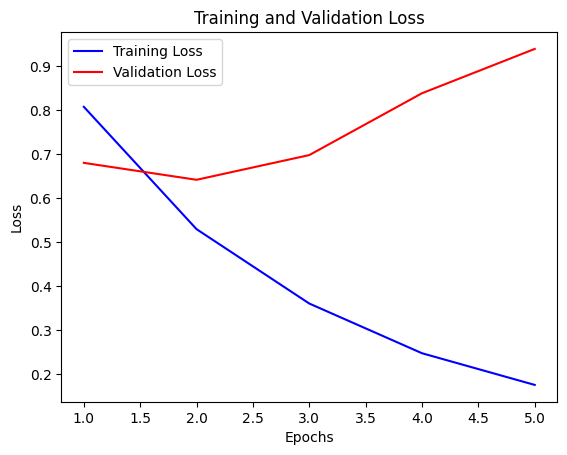

In [27]:
import matplotlib.pyplot as plt

# history 객체에서 훈련 손실값과 검증 손실값 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 에폭 수 만큼의 리스트 생성 (1, 2, 3, ..., epochs)
epochs = range(1, len(train_loss) + 1)

# 손실값 그래프 그리기
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 표시
plt.show()

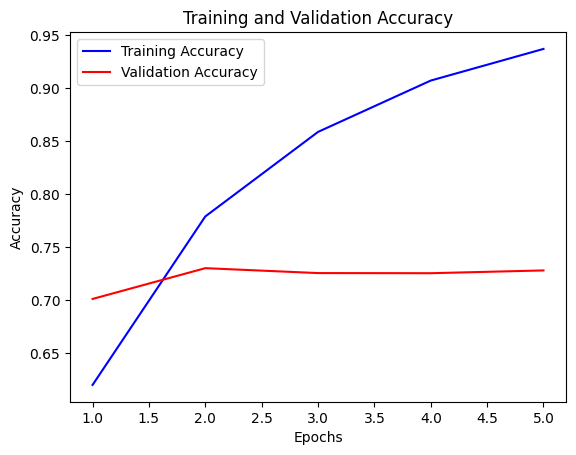

In [29]:
import matplotlib.pyplot as plt

# history 객체에서 훈련 정확도와 검증 정확도 추출
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# 에폭 수 만큼의 리스트 생성 (1, 2, 3, ..., epochs)
epochs = range(1, len(train_acc) + 1)

# 정확도 그래프 그리기
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프 표시
plt.show()

In [30]:
from tensorflow.keras.models import load_model

# 모델을 불러옵니다 (모델 파일명은 여기에서는 'your_model_filename.h5'로 가정)
loaded_model = load_model('checkpoint/model_lstm2.h5')


In [32]:
history = loaded_model.history
history

In [33]:
train_loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(train_loss) + 1)

# 손실값 그래프 그리기
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 그래프 표시
plt.show()

TypeError: 'NoneType' object is not subscriptable

---

In [96]:
# 최대 단어의 개수
max_features = 10000  # 특성으로 사용할 단어의 수
# 최대 단어 길이 (한번의 input당 들어갈 단어의 수)
maxlen = 200  # 시퀀스 길이

# 시퀀스 길이 맞춤
train_X = pad_sequences(tokens_train, maxlen=maxlen)
test_X = pad_sequences(tokens_test, maxlen=maxlen)

# LSTM 모델 구축
embedding_dim = 16
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=maxlen))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(8, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [94]:
# tokens_train과 tokens_test에서 가장 긴 요소의 길이 확인
max_len_train = max(len(seq) for seq in tokens_train)
max_len_test = max(len(seq) for seq in tokens_test)

print("tokens_train에서 가장 긴 요소의 길이:", max_len_train)
print("tokens_test에서 가장 긴 요소의 길이:", max_len_test)


tokens_train에서 가장 긴 요소의 길이: 3489
tokens_test에서 가장 긴 요소의 길이: 3179


In [98]:
# 체크포인트와 얼리스탑 콜백 설정
checkpoint_path = 'checkpoint/model_lstm.h5'  # 체크포인트 경로
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# 모델 학습
history = model.fit(train_X, train_y, epochs=10, batch_size=1024, validation_data=(test_X, test_y), callbacks=[checkpoint, early_stopping])
# 만약 과적합 나오면 batch_size 늘리면 됨 => 128정도

# 얼리스탑에 의해 학습이 중단된 경우 가장 좋은 모델을 로드합니다.
# best_model = load_model('checkpoint/model.h5')

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 1.0560 - accuracy: 0.4701 
Epoch 1: val_loss improved from inf to 1.05367, saving model to checkpoint\model_lstm.h5
32/32 [==============================] - 1052s 33s/step - loss: 1.0560 - accuracy: 0.4701 - val_loss: 1.0537 - val_accuracy: 0.4739
Epoch 2/10
 4/32 [==>...........................] - ETA: 15:53 - loss: 1.0540 - accuracy: 0.4675


KeyboardInterrupt



---

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np

In [6]:
data = nouns['명사']
target = nouns['감성분석결과']

train_X, test_X, train_y, test_y = train_test_split(data.values, target.values, 
                                                    test_size=0.2,
                                                    random_state=42)

In [7]:
# 텍스트 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)  # 훈련 데이터를 기반으로 토큰화
sequences_train = tokenizer.texts_to_sequences(train_X)
sequences_test = tokenizer.texts_to_sequences(test_X)

word_index = tokenizer.word_index
max_length = max([len(sequence) for sequence in sequences_train])
vocab_size = len(word_index) + 1

# 시퀀스 패딩 (모든 시퀀스 길이를 동일하게 맞춰줍니다)
train_X = pad_sequences(sequences_train, maxlen=max_length)
test_X = pad_sequences(sequences_test, maxlen=max_length)

# 레이블을 원-핫 인코딩으로 변환
train_y = to_categorical(train_y, num_classes=3)
test_y = to_categorical(test_y, num_classes=3)

In [8]:
train_y

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [9]:
# LSTM 모델 생성
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_length))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 출력 레이어 (다중 분류 - 3개의 클래스)

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# 체크포인트와 얼리스탑 콜백 설정
checkpoint_path = 'checkpoint/model_lstm.h5'  # 체크포인트 경로
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)

# 모델 학습
history = model.fit(train_X, train_y, epochs=10, batch_size=1024, validation_data=(test_X, test_y), callbacks=[checkpoint, early_stopping])

Epoch 1/10
